In [2]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## <a id="2">Import del Dataset (10%)</a>



In [10]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(
    'training.1600000.processed.noemoticon.csv',
    encoding=DATASET_ENCODING,
    names=DATASET_COLUMNS,
    on_bad_lines='skip'  # Salta le righe problematiche
).sample(frac=0.1, random_state=42)

dataset.head()

,sentiment,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [11]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

<ipython-input-11-11adef286a16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


In [12]:
# Contare i valori della colonna 'sentiment'
sentiment_counts = dataset['sentiment'].value_counts()
print(sentiment_counts)

sentiment
1    80188
0    79812
Name: count, dtype: int64


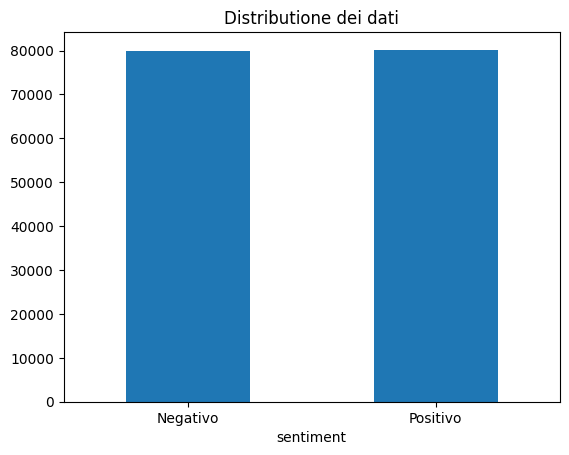

In [13]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distributione dei dati',
                                               legend=False)
ax = ax.set_xticklabels(['Negativo','Positivo'], rotation=0)

## <a id="3">Preprocessamento del testo</a>

1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **'http' or 'https' or 'www'** are replaced by **'<url\>'**.
3. **Replacing Usernames:** Replace @Usernames with word **'<user\>'**. [eg: '@Kaggle' to '<user\>'].
4. **Replacing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. [eg: 'Heyyyy' to 'Heyy']
5. **Replacing Emojis:** Replace emojis by using a regex expression. [eg: ':)' to '<smile\>']
6. **Replacing Contractions:** Replacing contractions with their meanings. [eg: "can't" to 'can not']
7. **Removing Non-Alphabets:** Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.


In [14]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [15]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 8.43 s, sys: 16.9 ms, total: 8.44 s
Wall time: 8.55 s


In [16]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Processed: <user> ahh i hope your ok   
Text: @misstoriblack cool , i have no tweet apps  for my razr 2
Processed: <user> cool   i have no tweet apps  for my razr 2
Text: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
Processed: <user> i know  just family drama  its lame hey next time u hang out with kim n u guys like have a sleepover or whatever  ill call u
Text: School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
Processed: school email will not open  and i have geography stuff on there to revise   stupid school  <sadface>
Text: upper airways problem 
Processed: upper airways problem 
Text: Going to miss Pastor's sermon on Faith... 
Processed: going to miss pastoris sermon on faith   
Text: on lunch....dj should come eat with me 
Processed: on lunch  dj should come eat with me 
Text: @piginthepoke oh why are yo

In [17]:
dataset.head()

,sentiment,text,processed_text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,<user> ahh i hope your ok
750,0,"@misstoriblack cool , i have no tweet apps fo...",<user> cool i have no tweet apps for my razr 2
766711,0,@TiannaChaos i know just family drama. its la...,<user> i know just family drama its lame hey...
285055,0,School email won't open and I have geography ...,school email will not open and i have geograp...
705995,0,upper airways problem,upper airways problem


## <a id="4">Analisi dei dati</a>


In [18]:
# Dividi in base ai sentimenti
data_neg = dataset[dataset['sentiment'] == 0]['processed_text'].tolist()  # Dati negativi
data_pos = dataset[dataset['sentiment'] == 1]['processed_text'].tolist()  # Dati positivi

print(f"Dimensione dati negativi: {len(data_neg)}")
print(f"Dimensione dati positivi: {len(data_pos)}")

Dimensione dati negativi: 79812
Dimensione dati positivi: 80188


### Word-Cloud per i tweet POSITIVI

In [19]:
from wordcloud import WordCloud, STOPWORDS
# stopwords predefinite
custom_stopwords = set(STOPWORDS)
custom_stopwords.add("user")
custom_stopwords.add("url")

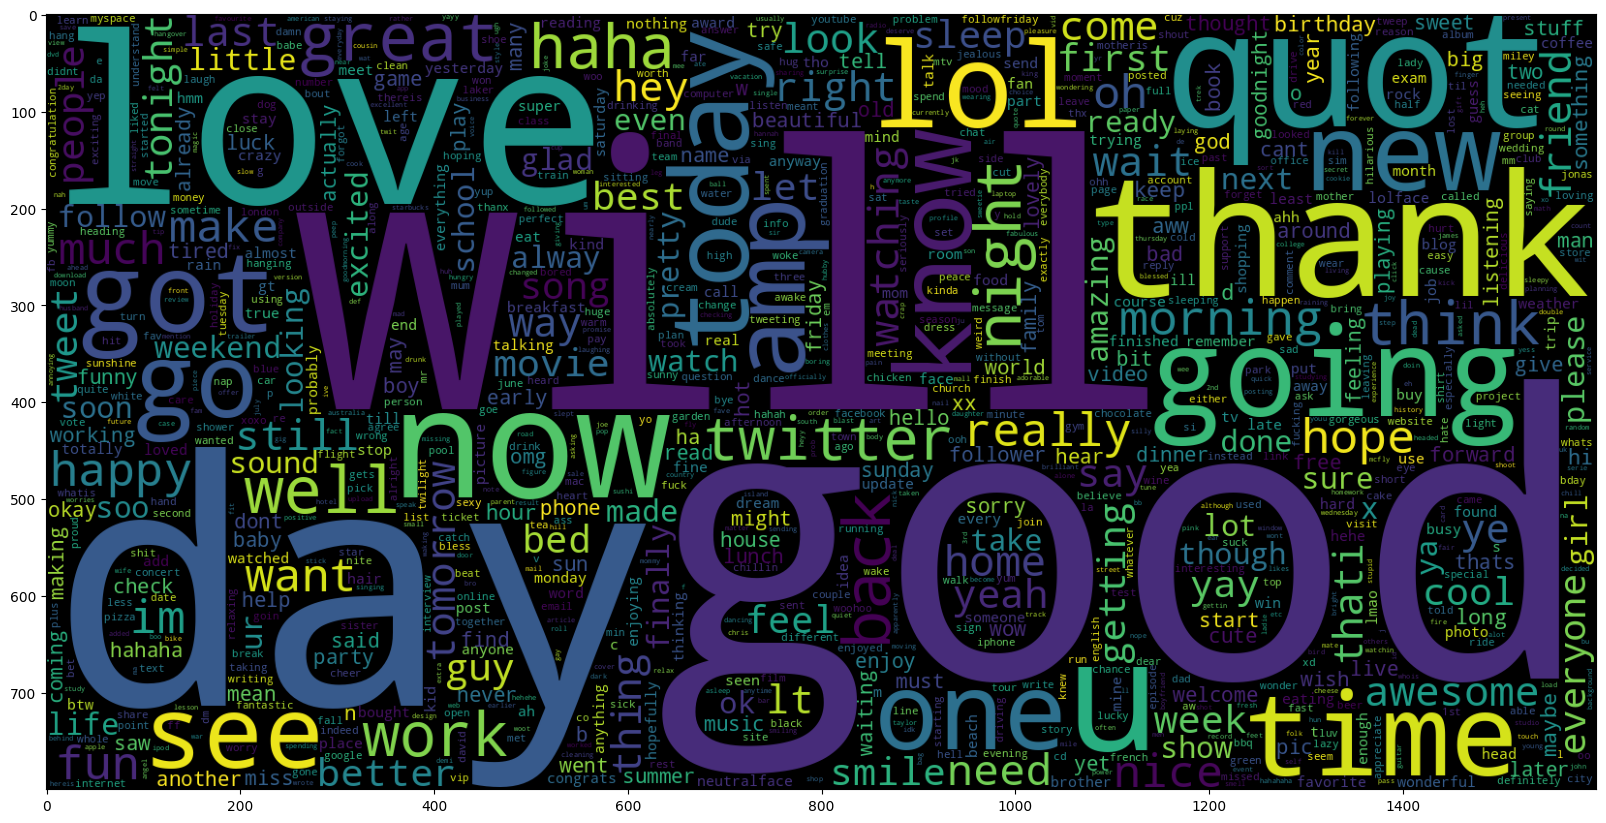

In [20]:
wc = WordCloud(max_words = 1000,
               width = 1600,
               height = 800,
               collocations=False,
               stopwords=custom_stopwords
              ).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Word-Cloud per i tweet NEGATIVI.

In [ ]:
wc = WordCloud(max_words = 1000,
               width = 1600,
               height = 800,
               collocations=False,
               stopwords=custom_stopwords
              ).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a id="5">Splitting dei dati</a>

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.2, random_state = 0)
print('Data Split done.')

Data Split done.


## <a id="6">Creazione dei Word Embeddings usando Word2Vec</a>


In [23]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [24]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 12458
CPU times: user 16.7 s, sys: 129 ms, total: 16.8 s
Wall time: 11.3 s


## <a id="7">Tokenizing and Padding datasets</a>



In [25]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [27]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (128000, 60)
X_test.shape : (32000, 60)


## <a id="8">Creating Embedding Matrix</a>



In [28]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


## <a id="9">Creating the Model</a>

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

### Architettura

In [30]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

### Model Summary

In [31]:
training_model = getModel()
training_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

## <a id="10">Training the Model</a>

###Callbacks

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Model Compile

In [33]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history = training_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.6897 - loss: 0.5799 - val_accuracy: 0.7356 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.7513 - loss: 0.5048 - val_accuracy: 0.7650 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.7643 - loss: 0.4833 - val_accuracy: 0.7695 - val_loss: 0.4780 - learning_rate: 0.0010
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.7724 - loss: 0.4699 - val_accuracy: 0.7770 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.7783 - loss: 0.4587 - val_accuracy: 0.7784 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.7806 - loss: 0.4557 - val_accuracy: 0.7843 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7

## <a id="11">Valutazione del modello</a>

### Curva di apprendimento

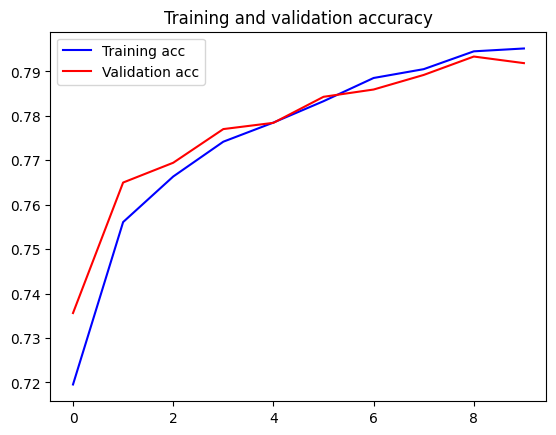

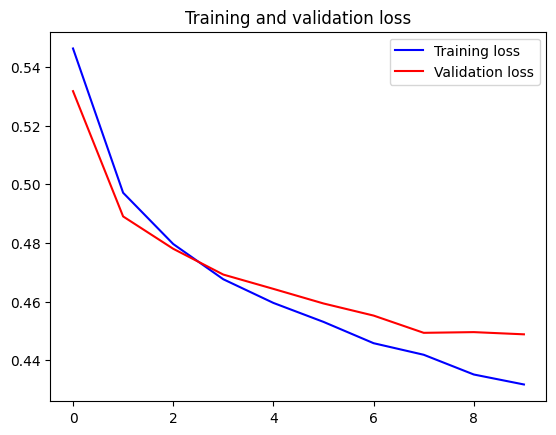

In [35]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Matrice di confusione

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


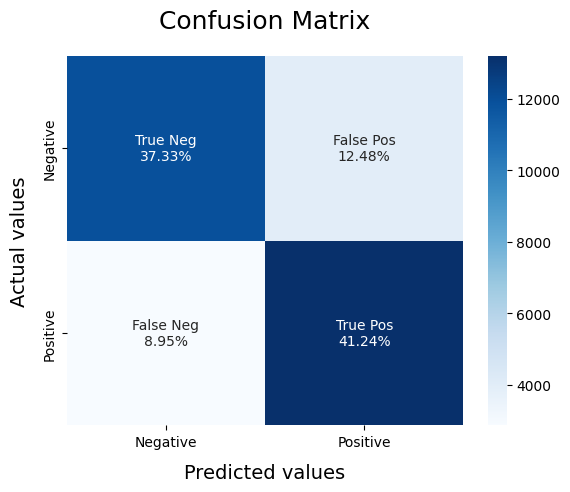

In [37]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_test)

### Precision, Recall, F1-Score, Accuracy

In [38]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     15937
           1       0.77      0.82      0.79     16063

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000

